# Reflectance and Transmittance Spectra for Planewave at Oblique Incidence

As an additional demonstration of the mode-decomposition feature, the reflectance and transmittance of all diffracted orders for any grating with no material absorption and a planewave source incident at any arbitrary angle and wavelength must necessarily sum to unity. Also, the total reflectance and transmittance must be equivalent to values computed using the Poynting flux. This demonstration is somewhat similar to the [single-mode waveguide example](https://nbviewer.jupyter.org/github/NanoComp/meep/blob/master/python/examples/mode-decomposition.ipynb).

The following example is adapted from the previous binary-grating example involving a [normally-incident planewave](https://nbviewer.jupyter.org/github/NanoComp/meep/blob/master/python/examples/binary_grating.ipynb). 

The total reflectance, transmittance, and their sum are plotted at the end of the simulation.

Results are computed for a single wavelength of 0.5 μm. The pulsed planewave is incident at an angle of 10.7°. Its spatial profile is defined using the source amplitude function `pw_amp`. This [anonymous function](https://en.wikipedia.org/wiki/Anonymous_function) takes two arguments, the wavevector and a point in space (both `mp.Vector3`s), and returns a function of one argument which defines the planewave amplitude at that point. A narrow bandwidth pulse is used in order to mitigate the intrinsic discretization effects of the [Yee grid](../Yee_Lattice.md) for oblique planewaves. Also, the `stop_when_fields_decayed` termination criteria is replaced with `until_after_sources`. As a general rule of thumb, the more oblique the planewave source, the longer the run time required to ensure accurate results. There is an additional line monitor between the source and the grating for computing the reflectance. The angle of each reflected/transmitted mode, which can be positive or negative, is computed using its dominant planewave vector. Since the oblique source breaks the symmetry in the $y$ direction, each diffracted order must be computed separately. In total, there are 59 reflected and 39 transmitted orders.

As usual, we'll begin by loading our required modules:

In [1]:
import meep as mp
import math
import cmath
import numpy as np
from matplotlib import pyplot as plt

Using MPI version 3.1, 1 processes


Next we'll define our simulation domain:

In [2]:
resolution = 50  # pixels/μm

dpml = 1.0  # PML thickness
dsub = 3.0  # substrate thickness
dpad = 3.0  # length of padding between grating and PML
gp = 10.0  # grating period
gh = 0.5  # grating height
gdc = 0.5  # grating duty cycle

sx = dpml + dsub + gh + dpad + dpml
sy = gp

cell_size = mp.Vector3(sx, sy, 0)
pml_layers = [mp.PML(thickness=dpml, direction=mp.X)]

We can now define the oblique source we'll use to excite the grating structure.

In [3]:
ng = 1.5
glass = mp.Medium(index=ng)

wvl = 0.5  # center wavelength
fcen = 1 / wvl  # center frequency
df = 0.05 * fcen  # frequency width

# rotation angle of incident planewave; counter clockwise (CCW) about Z axis, 0 degrees along +X axis
theta_in = math.radians(10.7)

# k (in source medium) with correct length (plane of incidence: XY)
k = mp.Vector3(fcen * ng).rotate(mp.Vector3(z=1), theta_in)

symmetries = []
eig_parity = mp.ODD_Z
if theta_in == 0:
    k = mp.Vector3(0, 0, 0)
    symmetries = [mp.Mirror(mp.Y)]
    eig_parity += mp.EVEN_Y


def pw_amp(k, x0):
    def _pw_amp(x):
        return cmath.exp(1j * 2 * math.pi * k.dot(x + x0))

    return _pw_amp


src_pt = mp.Vector3(-0.5 * sx + dpml + 0.3 * dsub, 0, 0)
sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=src_pt,
        size=mp.Vector3(0, sy, 0),
        amp_func=pw_amp(k, src_pt),
    )
]

We'll now initialize our simulation object. Since our first run is a normalization run, we'll set the entire domain to be the same material (glass in this case).

In [4]:
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    k_point=k,
    default_material=glass,
    sources=sources,
    symmetries=symmetries,
)

refl_pt = mp.Vector3(-0.5 * sx + dpml + 0.5 * dsub, 0, 0)
refl_flux = sim.add_flux(
    fcen, 0, 1, mp.FluxRegion(center=refl_pt, size=mp.Vector3(0, sy, 0))
)

Since everything looks as expected, we can now run our normalization simulation. We'll record the flux data for future use.

In [5]:
sim.run(until_after_sources=100)

input_flux = mp.get_fluxes(refl_flux)
input_flux_data = sim.get_flux_data(refl_flux)

-----------
Initializing structure...
Meep: using complex fields.
Meep progress: 9.32/200.0 = 4.7% done in 4.0s, 81.9s to go
Meep progress: 17.79/200.0 = 8.9% done in 8.0s, 82.0s to go
Meep progress: 26.91/200.0 = 13.5% done in 12.0s, 77.2s to go
Meep progress: 36.730000000000004/200.0 = 18.4% done in 16.0s, 71.2s to go
Meep progress: 46.550000000000004/200.0 = 23.3% done in 20.0s, 66.0s to go
Meep progress: 56.34/200.0 = 28.2% done in 24.0s, 61.2s to go
Meep progress: 66.34/200.0 = 33.2% done in 28.0s, 56.4s to go
Meep progress: 76.15/200.0 = 38.1% done in 32.0s, 52.1s to go
Meep progress: 86.03/200.0 = 43.0% done in 36.0s, 47.7s to go
Meep progress: 95.34/200.0 = 47.7% done in 40.0s, 43.9s to go
Meep progress: 104.71000000000001/200.0 = 52.4% done in 44.0s, 40.1s to go
Meep progress: 114.54/200.0 = 57.3% done in 48.0s, 35.8s to go
Meep progress: 124.45/200.0 = 62.2% done in 52.0s, 31.6s to go
Meep progress: 134.25/200.0 = 67.1% done in 56.0s, 27.4s to go
Meep progress: 144.12/200.0 =

We'll now reset our simulation domain using the `reset_meep` command and generate the periodic grating structure.

In [6]:
sim.reset_meep()

geometry = [
    mp.Block(
        material=glass,
        size=mp.Vector3(dpml + dsub, mp.inf, mp.inf),
        center=mp.Vector3(-0.5 * sx + 0.5 * (dpml + dsub), 0, 0),
    ),
    mp.Block(
        material=glass,
        size=mp.Vector3(gh, gdc * gp, mp.inf),
        center=mp.Vector3(-0.5 * sx + dpml + dsub + 0.5 * gh, 0, 0),
    ),
]

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    k_point=k,
    sources=sources,
    symmetries=symmetries,
)

refl_flux = sim.add_flux(
    fcen, 0, 1, mp.FluxRegion(center=refl_pt, size=mp.Vector3(0, sy, 0))
)
sim.load_minus_flux_data(refl_flux, input_flux_data)

tran_pt = mp.Vector3(0.5 * sx - dpml - 0.5 * dpad, 0, 0)
tran_flux = sim.add_flux(
    fcen, 0, 1, mp.FluxRegion(center=tran_pt, size=mp.Vector3(0, sy, 0))
)

-----------
Initializing structure...
     block, center = (-2.25,0,0)
          size (4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (0.5,5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Meep: using complex fields.


Finally, we'll simulate the actual grating structure.

In [7]:
sim.run(until_after_sources=200)

Meep progress: 9.58/300.0 = 3.2% done in 4.0s, 121.4s to go
Meep progress: 18.59/300.0 = 6.2% done in 8.0s, 121.2s to go
Meep progress: 28.060000000000002/300.0 = 9.4% done in 12.0s, 116.4s to go
Meep progress: 37.59/300.0 = 12.5% done in 16.0s, 111.8s to go
Meep progress: 47.0/300.0 = 15.7% done in 20.0s, 107.7s to go
Meep progress: 56.58/300.0 = 18.9% done in 24.0s, 103.3s to go
Meep progress: 65.96000000000001/300.0 = 22.0% done in 28.0s, 99.4s to go
Meep progress: 75.53/300.0 = 25.2% done in 32.0s, 95.2s to go
Meep progress: 85.19/300.0 = 28.4% done in 36.0s, 90.8s to go
Meep progress: 94.8/300.0 = 31.6% done in 40.0s, 86.6s to go
Meep progress: 103.02/300.0 = 34.3% done in 44.0s, 84.2s to go
Meep progress: 108.78/300.0 = 36.3% done in 48.0s, 84.4s to go
Meep progress: 117.64/300.0 = 39.2% done in 52.0s, 80.7s to go
Meep progress: 126.28/300.0 = 42.1% done in 56.0s, 77.1s to go
Meep progress: 134.91/300.0 = 45.0% done in 60.0s, 73.5s to go
Meep progress: 144.69/300.0 = 48.2% done i

With both simulation runs complete, we can use the `get_eigenmode_coefficients` routine to extract the reflection and transmission diffraction orders and relative power.

In [8]:
# Calculate the number of reflected orders
nm_r = np.floor((fcen * ng - k.y) * gp) - np.ceil(
    (-fcen * ng - k.y) * gp
)  # number of reflected orders
if theta_in == 0:
    nm_r = nm_r / 2  # since eig_parity removes degeneracy in y-direction
nm_r = int(nm_r)

# Extract the coefficients for the reflected orders
res = sim.get_eigenmode_coefficients(
    refl_flux, range(1, nm_r + 1), eig_parity=eig_parity
)
r_coeffs = res.alpha

# Calculate the number of transmitted orders
nm_t = np.floor((fcen - k.y) * gp) - np.ceil(
    (-fcen - k.y) * gp
)  # number of transmitted orders
if theta_in == 0:
    nm_t = nm_t / 2  # since eig_parity removes degeneracy in y-direction
nm_t = int(nm_t)

# Extract the coefficients for the transmitted orders
res = sim.get_eigenmode_coefficients(
    tran_flux, range(1, nm_t + 1), eig_parity=eig_parity
)
t_coeffs = res.alpha

    iteration   60: trace = 166.7770726644721 (1.83568e-09% change)
    iteration   55: trace = 177.9876051266832 (7.99025e-10% change)
    iteration   51: trace = 189.5448069917852 (5.38133e-07% change)
    iteration   48: trace = 201.4664481059231 (1.8864e-08% change)
    iteration   46: trace = 207.5342915143063 (3.85266e-10% change)
    iteration   43: trace = 213.7703137192983 (4.51554e-09% change)
    iteration   41: trace = 220.034335071049 (1.36799e-09% change)
    iteration   41: trace = 226.4741893511782 (4.77871e-07% change)
    iteration   41: trace = 232.9432676387035 (5.52227e-08% change)
    iteration   39: trace = 239.595834286208 (3.53174e-06% change)
    iteration   38: trace = 246.2788666241614 (2.25977e-09% change)
    iteration   37: trace = 253.1530499209222 (9.10884e-06% change)
    iteration   37: trace = 260.0589101770202 (1.34992e-09% change)
    iteration   35: trace = 267.1635561942985 (5.91227e-07% change)
    iteration   35: trace = 274.3011759549739 (1.72

Finally, we'll compute the corresponding angles and relative powers and visualize the results.

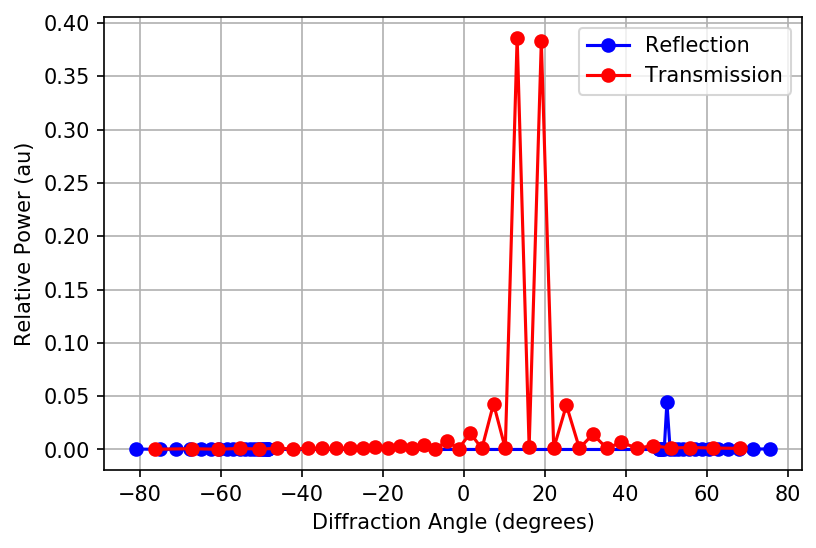

In [9]:
r_angle = np.squeeze(
    [
        math.degrees(np.sign(r_kdom.y) * math.acos(r_kdom.x / (ng * fcen)))
        for r_kdom in res.kdom
    ]
)
Rmode = abs(r_coeffs[:, 0, 1]) ** 2 / input_flux[0]
idx_r = np.argsort(r_angle)

t_angle = np.squeeze(
    [
        math.degrees(np.sign(t_kdom.y) * math.acos(t_kdom.x / fcen))
        for t_kdom in res.kdom
    ]
)
Tmode = abs(t_coeffs[:, 0, 0]) ** 2 / input_flux[0]
idx_t = np.argsort(t_angle)

plt.figure(dpi=150)
plt.plot(r_angle[idx_r], Rmode[idx_r], "o-", color="blue", label="Reflection")
plt.plot(t_angle[idx_t], Tmode[idx_t], "o-", color="red", label="Transmission")
plt.grid(True)
plt.xlabel("Diffraction Angle (degrees)")
plt.ylabel("Relative Power (au)")
plt.legend()
plt.show()

As a sanity check, we'll compare the total flux derived from the `get_eigenmode_coefficients` routine to the flux computed from the flux monitors:

In [10]:
print(
    "mode-coeff:, {:.6f}, {:.6f}, {:.6f}".format(
        np.sum(Rmode), np.sum(Tmode), np.sum(Rmode) + np.sum(Tmode)
    )
)
r_flux = mp.get_fluxes(refl_flux)
t_flux = mp.get_fluxes(tran_flux)
Rflux = -r_flux[0] / input_flux[0]
Tflux = t_flux[0] / input_flux[0]
print("poynting-flux:, {:.6f}, {:.6f}, {:.6f}".format(Rflux, Tflux, Rflux + Tflux))

mode-coeff:, 0.061047, 0.937862, 0.998909
poynting-flux:, 0.061102, 0.938344, 0.999447
